## Image Classification using CNN

In [22]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf

In [23]:
train_dir = 'tourism_destination_2/tourism_destination/train_data/'
validation_dir = 'tourism_destination_2/tourism_destination/validation_data/'

In [24]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory( 
        train_dir, 
        target_size=(150, 150), 
        batch_size=32,
        class_mode='categorical')

# genereate 100 augmantation
augmentation_count = 200

for i in range(augmentation_count):
    # take image batch from generator
    batch_images, batch_labels = train_generator.next()

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical') 

Found 1396 images belonging to 16 classes.
Found 222 images belonging to 16 classes.


In [25]:
#Build a Model
def create_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(16, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4), #experiment with lr = 1e-2, 1e-5 and 1e-6 stuck in local minimum (acc=2.55xxx)
                metrics=['accuracy'])
  
    return model

model=create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [26]:
from keras.callbacks import History

# Create an instance of the History callback
history_callback = History()

In [27]:
history = model.fit(   
      train_generator,
      epochs=200,
      steps_per_epoch=1396 // 32,
      validation_data=validation_generator,
      validation_steps=222//32, 
      verbose=2,
      callbacks=[history_callback])

Epoch 1/200
43/43 - 28s - loss: 2.6020 - accuracy: 0.1342 - val_loss: 2.7704 - val_accuracy: 0.0417 - 28s/epoch - 659ms/step
Epoch 2/200
43/43 - 26s - loss: 2.4872 - accuracy: 0.2009 - val_loss: 2.5158 - val_accuracy: 0.1667 - 26s/epoch - 597ms/step
Epoch 3/200
43/43 - 26s - loss: 2.3652 - accuracy: 0.2412 - val_loss: 2.3610 - val_accuracy: 0.3177 - 26s/epoch - 611ms/step
Epoch 4/200
43/43 - 27s - loss: 2.2891 - accuracy: 0.2676 - val_loss: 2.2696 - val_accuracy: 0.3490 - 27s/epoch - 621ms/step
Epoch 5/200
43/43 - 26s - loss: 2.2309 - accuracy: 0.2933 - val_loss: 2.3373 - val_accuracy: 0.3385 - 26s/epoch - 599ms/step
Epoch 6/200
43/43 - 26s - loss: 2.1419 - accuracy: 0.3270 - val_loss: 2.0269 - val_accuracy: 0.4219 - 26s/epoch - 595ms/step
Epoch 7/200
43/43 - 26s - loss: 2.1094 - accuracy: 0.3218 - val_loss: 2.0096 - val_accuracy: 0.3385 - 26s/epoch - 610ms/step
Epoch 8/200
43/43 - 26s - loss: 2.0305 - accuracy: 0.3688 - val_loss: 1.9760 - val_accuracy: 0.3438 - 26s/epoch - 615ms/step


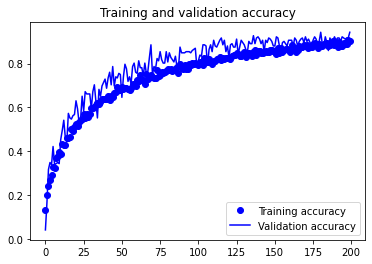

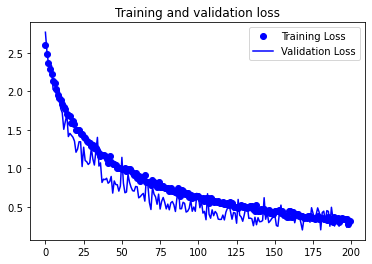

In [28]:
# plot the summary training
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_loss_acc(history)

In [29]:
# Save the entire model
model.save("model8.h5")

# Save only the model weights
model.save_weights("weights8.h5")


import json

history = history_callback.history

# Save the history dictionary to a JSON file
with open('epoch_history8.json', 'w') as f:
    json.dump(history, f)

In [30]:
model = tf.keras.models.load_model('model7.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model8.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\CATURW~1\AppData\Local\Temp\tmpazz6g18b\assets


INFO:tensorflow:Assets written to: C:\Users\CATURW~1\AppData\Local\Temp\tmpazz6g18b\assets


Transfer learning (belum dicoba)
